TKO_3120 Machine Learning and Pattern Recognition

Image recognition exercise

Marko Loponen <br>
majulop@utu.fi

February 2020

---

# Report

## Introduction

Purpose of this task is to validate three different machine learning classifiers for recognizing images. For providing the image data in a format these classifiers understand, it is necessary to prepare the data with various methods, such as, exctract features from the image and lower the complexity and dimensions of the data, and also remove unnecessary features.

The data used to validate these models were received from https://unplash.com, as their license for the images is extra ordinary;
> All photos published on Unsplash can be used for free. You can use them for commercial and noncommercial purposes.

#### Methods used on this task were:

Data preparation:

* [Resize](https://www.quora.com/What-is-resizing-images-and-what-are-the-parameters-to-change-the-size-of-the-picture) to normalize the image data 
* [Grayscale](https://whatis.techtarget.com/definition/grayscale) for using the image in more simple form
* [First order texture features (RGB mean and variance)](https://cran.r-project.org/web/packages/radiomics/vignettes/TextureAnalysis.html) to provide our classifiers simple features to understand
* [Quantizing](https://www.tutorialspoint.com/dip/Concept_of_Quantization.htm) for reducing grayscale image dimensions
* [Gray-Level-Co-Occurrence](https://prism.ucalgary.ca/handle/1880/51900) for providing the smoothness / roughness of the image with second order texture calculation.
* [GLCM Texture properties](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycoprops) for extracting features from the grey level co-occurrence matrix in a simple format
* [Pairplot](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) is used for better understanding any linear correlation between two features
* [PCA](https://users.ics.aalto.fi/jhollmen/dippa/node30.html) to reduce all features into 2-dimension and plot them to view is there any correlation between the clusters

Classification:

* [k-Nearest Neighbours classifier](https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering) 
* [Ridge Regression](https://www.statlect.com/fundamentals-of-statistics/ridge-regression)
* [Multilayer perceptron](https://users.ics.aalto.fi/ahonkela/dippa/node41.html) 

Validation of the classifiers:
* [Leave One Out](https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-30164-8_469)
* [Nested Cross-validation](https://www.elderresearch.com/blog/nested-cross-validation)

Performance boost:
* [Multiprocessing](https://sebastianraschka.com/Articles/2014_multiprocessing.html) to enable Leave One Out and Nested Cross-validation in the validation of classifiers accuracy, multiprocessing methods are used to cut down the calculation time. From start to finish running all these steps take approx. six hours from computer with 8 core processor (16 threads) on 4.35Ghz clockspeed. Multiprocessing functions are in external file 'lobster.py' and __need to be loaded externally__ to the Jupyter Notebook. File can be viewed at the end of this document.

### Data preparation

We start by fetching the images from the [website](http://unplash.com), rezising them (200x200 pixels), grayscaling them to new images with quantization (8 levels) and saving them to [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, img_as_float
from skimage.transform import resize
from skimage.color import rgb2gray
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from skimage.feature import greycomatrix, greycoprops
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import RidgeClassifier
from sklearn import preprocessing

from multiprocessing import Pool
import multiprocessing as mp
import lobster

from datetime import datetime
from sklearn.neural_network import MLPClassifier

from itertools import product

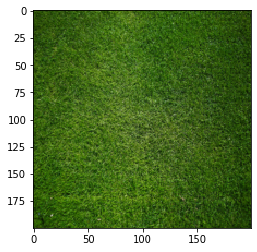

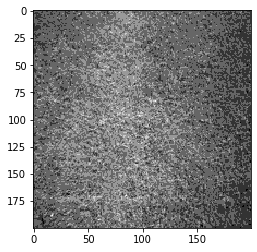

In [2]:
urls = {"grass": np.loadtxt('grass.txt', dtype='U150'), "sand": np.loadtxt('sand.txt', dtype='U150'), "stairs": np.loadtxt('stairs.txt', dtype='U150')}

image_x = 200
image_y = 200
quantization_level = 8

images = pd.DataFrame()


def quantize(image, L=1, N=4):
    """Quantize an image. 
    
    Source    Date: 30.1.2020
    ------------------------------
    https://github.com/scikit-image/skimage-demos/blob/master/dither.py
    
    Parameters
    ----------
    image : array_like
        Input image.
    L : float
        Maximum input value.
    N : int
        Number of quantization levels.
    """
    T = np.linspace(0, L, N, endpoint=False)[1:]
    return np.digitize(image.flat, T).reshape(image.shape)



""" Reads every image, makes it grayscale, resizes, transforms it to float values, quantizes and appends to its
correresponding category in the images-variable.

"""
temp = {"images": [], "gray_images": [], "categories": []}
for category in urls:
    for im in urls[category]:
        
        img = resize(io.imread(im), (image_x,image_y), anti_aliasing=True)
        """ Color image
        """
        
        imggray = img_as_float(rgb2gray(img))
        imggray2 = quantize(imggray.copy(), N=quantization_level)
        """ Gray image
        """
        
        temp['images'].append(img)
        temp['gray_images'].append(imggray2)
        temp['categories'].append(category)
        """ Add the images to temps
        """
        
        
        
images['image'] = temp['images']
images['gray_image'] = temp['gray_images']
images['category'] = temp['categories']
        

        

""" Set our test image to variable
"""

""" Validates that the images are grayscale, color and right size.
"""
plt.imshow(images['image'][0])
plt.show()
plt.imshow(images['gray_image'][0], cmap='gray')
plt.show()



## Feature extraction

### First order texture measures (9 features)

Next we calculate First Order texture measurements (mean and variance for each color channel (red, green, blue)) for the color images. These achieved features provides our classifiers easy to calculate values.

In [3]:
""" Calculate and set values for each image
"""

temp = {'r_mean':[],'g_mean':[],'b_mean':[],'r_var':[],'g_var':[],'b_var':[]}
""" temp dictionary
"""

for image in images['image']:
    
    r = image[:,:,0] * 255
    g = image[:,:,1] * 255
    b = image[:,:,2] * 255
    """ Get image RGB values
    """
    
    temp['r_mean'].append(np.mean(r))
    temp['g_mean'].append(np.mean(g))
    temp['b_mean'].append(np.mean(b))
    """ Save mean of RGB values
    """
    
    temp['r_var'].append(np.var(r))
    temp['g_var'].append(np.var(g))
    temp['b_var'].append(np.var(b))
    """ Save variance of RGB values
    """

""" Savint the values to images dataframe
"""
images['r_mean'] = temp['r_mean']
images['g_mean'] = temp['g_mean']
images['b_mean'] = temp['b_mean']
images['r_var'] = temp['r_var']
images['g_var'] = temp['g_var']
images['b_var'] = temp['b_var']

### Second order texture measures (4 or 7 features)

In this step we calculate Gray-Level-Co-Occurence features by calculating GLC matrix. With correlation feature using the matrix we are calculation it with distances one and five to angles zero and ninety. The distances are chosen to be one and five, as one is provides high chance of correlation on the adjacent pixel and five provides lower chance of correlation on the adjacent pixel, so it would be understandable to chose two numbers which are not close to each others. Altought the longer distance is chosen arbitrary, yet too high number would not be beneficial due to lower chance of correlation.

The calculated values are added to images DataFrame.

In [4]:
""" Calculate and set values for each gray image
"""

temp = {'greycomatrix':[], 'greycomatrix_correlation':[], 'greycomatrix_energy':[], 'greycomatrix_asm':[], 'greycomatrix_homogeneity':[], 'greycomatrix_dissimilarity':[], 'greycomatrix_contrast':[]}
""" Temp dictionary for inserting the values to dataframe
"""

distances = [1,5]
angles = [0,90]
""" Distances and angles for the greycomatrix
"""


genkey = ['greycomatrix_correlation', 'greycomatrix_energy', 'greycomatrix_asm', 'greycomatrix_homogeneity','greycomatrix_dissimilarity','greycomatrix_contrast']
for f in genkey:
    for d in distances:
        for a in angles:
            temp[f + "-" + str(d) + "-" + str(a)] = []
""" Generating the keys to temp dictionary per distance and angle.
    Example: greycomatrix_asm-1-0, greycomatrix_asm-1-90, greycomatrix_asm-5-0, greycomatrix_asm-5-90 ...
"""


for image in images['gray_image']:
    """ Process the gray images
    """

    glcm = greycomatrix(image, distances, angles, levels=8, symmetric=True, normed=True)
    """ GLCM, symmetric and normalized
    """
    
    temp['greycomatrix'].append(glcm)
    temp['greycomatrix_correlation'].append(greycoprops(glcm, 'correlation'))
    temp['greycomatrix_energy'].append(greycoprops(glcm, 'energy'))
    temp['greycomatrix_asm'].append(greycoprops(glcm, 'ASM'))
    temp['greycomatrix_homogeneity'].append(greycoprops(glcm, 'homogeneity'))
    temp['greycomatrix_dissimilarity'].append(greycoprops(glcm, 'dissimilarity'))
    temp['greycomatrix_contrast'].append(greycoprops(glcm, 'contrast'))
    """ Save the GLCM and features to temp dictionary
    """
    
    for f in genkey:
        feat = temp[f][len(temp[f])-1]
        for d,r in enumerate(feat):
            for a,l in enumerate(r):
                temp[f + "-" + str(distances[d]) + "-" + str(angles[a])].append(l)
    """ Save the last processed gray image features to columns
        Example: 
        
                temp['greycomatrix_correlation'] = [[ 0.58333333,  1.        ],
                                                   [ 1.25      ,  2.75      ]]
                
                to
                
                temp['greycomatrix_correlation-1-0']  = 0.58333333
                temp['greycomatrix_correlation-1-90'] = 1
                temp['greycomatrix_correlation-5-0']  = 1.25
                temp['greycomatrix_correlation-5-90'] = 2.75
    """
    

for k in temp:
    images[k] = temp[k]
    """ Add the calculated features to the image
    """
    
""" Display the head of images dataframe
"""
display(images.head())

image  \
0  [[[0.25215686274510385, 0.4377254901960847, 0....   
1  [[[0.4771176470588242, 0.598686274509804, 0.70...   
2  [[[0.11594117647059168, 0.44756862745096926, 0...   
3  [[[0.40851960784313757, 0.4640980392156868, 0....   
4  [[[0.6, 0.7176470588235294, 0.3333333333333333...   

                                          gray_image category      r_mean  \
0  [[2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2,...    grass   59.433152   
1  [[4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 4, 5, 4, 4,...    grass  117.525387   
2  [[2, 2, 1, 1, 1, 2, 3, 2, 3, 2, 3, 2, 3, 2, 1,...    grass   23.520541   
3  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...    grass  100.180339   
4  [[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,...    grass  107.099293   

       g_mean      b_mean        r_var        g_var        b_var  \
0   97.061349   20.962426   364.848413   457.992950   152.928438   
1  137.627034  121.527695  4128.702703  3252.073048  5468.544932   
2   86.526053   12.751648   233.668662  2166.723073   170.277629   
3  116.662128   21.299531   793.633755   920.524632   383.302193   
4  150.654951   37.677554  2034.344788  1437.435782  1325.119160   

                                        greycomatrix  ...  \
0  [[[[0.00012563 0.00022613], [0. 0.]], [[0.0010...  ...   
1  [[[[0.01253769 0.01095477], [0.00948718 0.0041...  ...   
2  [[[[0.1111809 0.1188191], [0.04284615 0.046820...  ...   
3  [[[[0.00354271 0.00527638], [0.00094872 0.0012...  ...   
4  [[[[0.00278894 0.00472362], [0.00087179 0.0015...  ...   

  greycomatrix_homogeneity-5-0 greycomatrix_homogeneity-5-90  \
0                     0.746765                      0.740725   
1                     0.842075                      0.806097   
2                     0.502001                      0.509611   
3                     0.698710                      0.705006   
4                     0.756631                      0.787404   

  greycomatrix_dissimilarity-1-0 greycomatrix_dissimilarity-1-90  \
0                       0.407839                        0.425176   
1                       0.165302                        0.210829   
2                       0.617839                        0.570377   
3                       0.432513                        0.334598   
4                       0.282739                        0.127563   

  greycomatrix_dissimilarity-5-0 greycomatrix_dissimilarity-5-90  \
0                       0.523256                        0.536178   
1                       0.348974                        0.463023   
2                       1.251231                        1.228999   
3                       0.660436                        0.637291   
4                       0.536077                        0.463307   

   greycomatrix_contrast-1-0  greycomatrix_contrast-1-90  \
0                   0.431357                    0.457688   
1                   0.186608                    0.256005   
2                   0.840101                    0.766508   
3                   0.505879                    0.374497   
4                   0.333090                    0.141332   

   greycomatrix_contrast-5-0  greycomatrix_contrast-5-90  
0                   0.607256                    0.624356  
1                   0.531128                    0.883555  
2                   2.554051                    2.496161  
3                   0.951718                    0.875026  
4                   0.792436                    0.660534  

[5 rows x 40 columns]

## Feature relationships

In here we visualize and analyze does these achieved features show any relationships.

### Pairplot
Pairplot shows us the correlation between two features in one view where we can notice relationships of them.

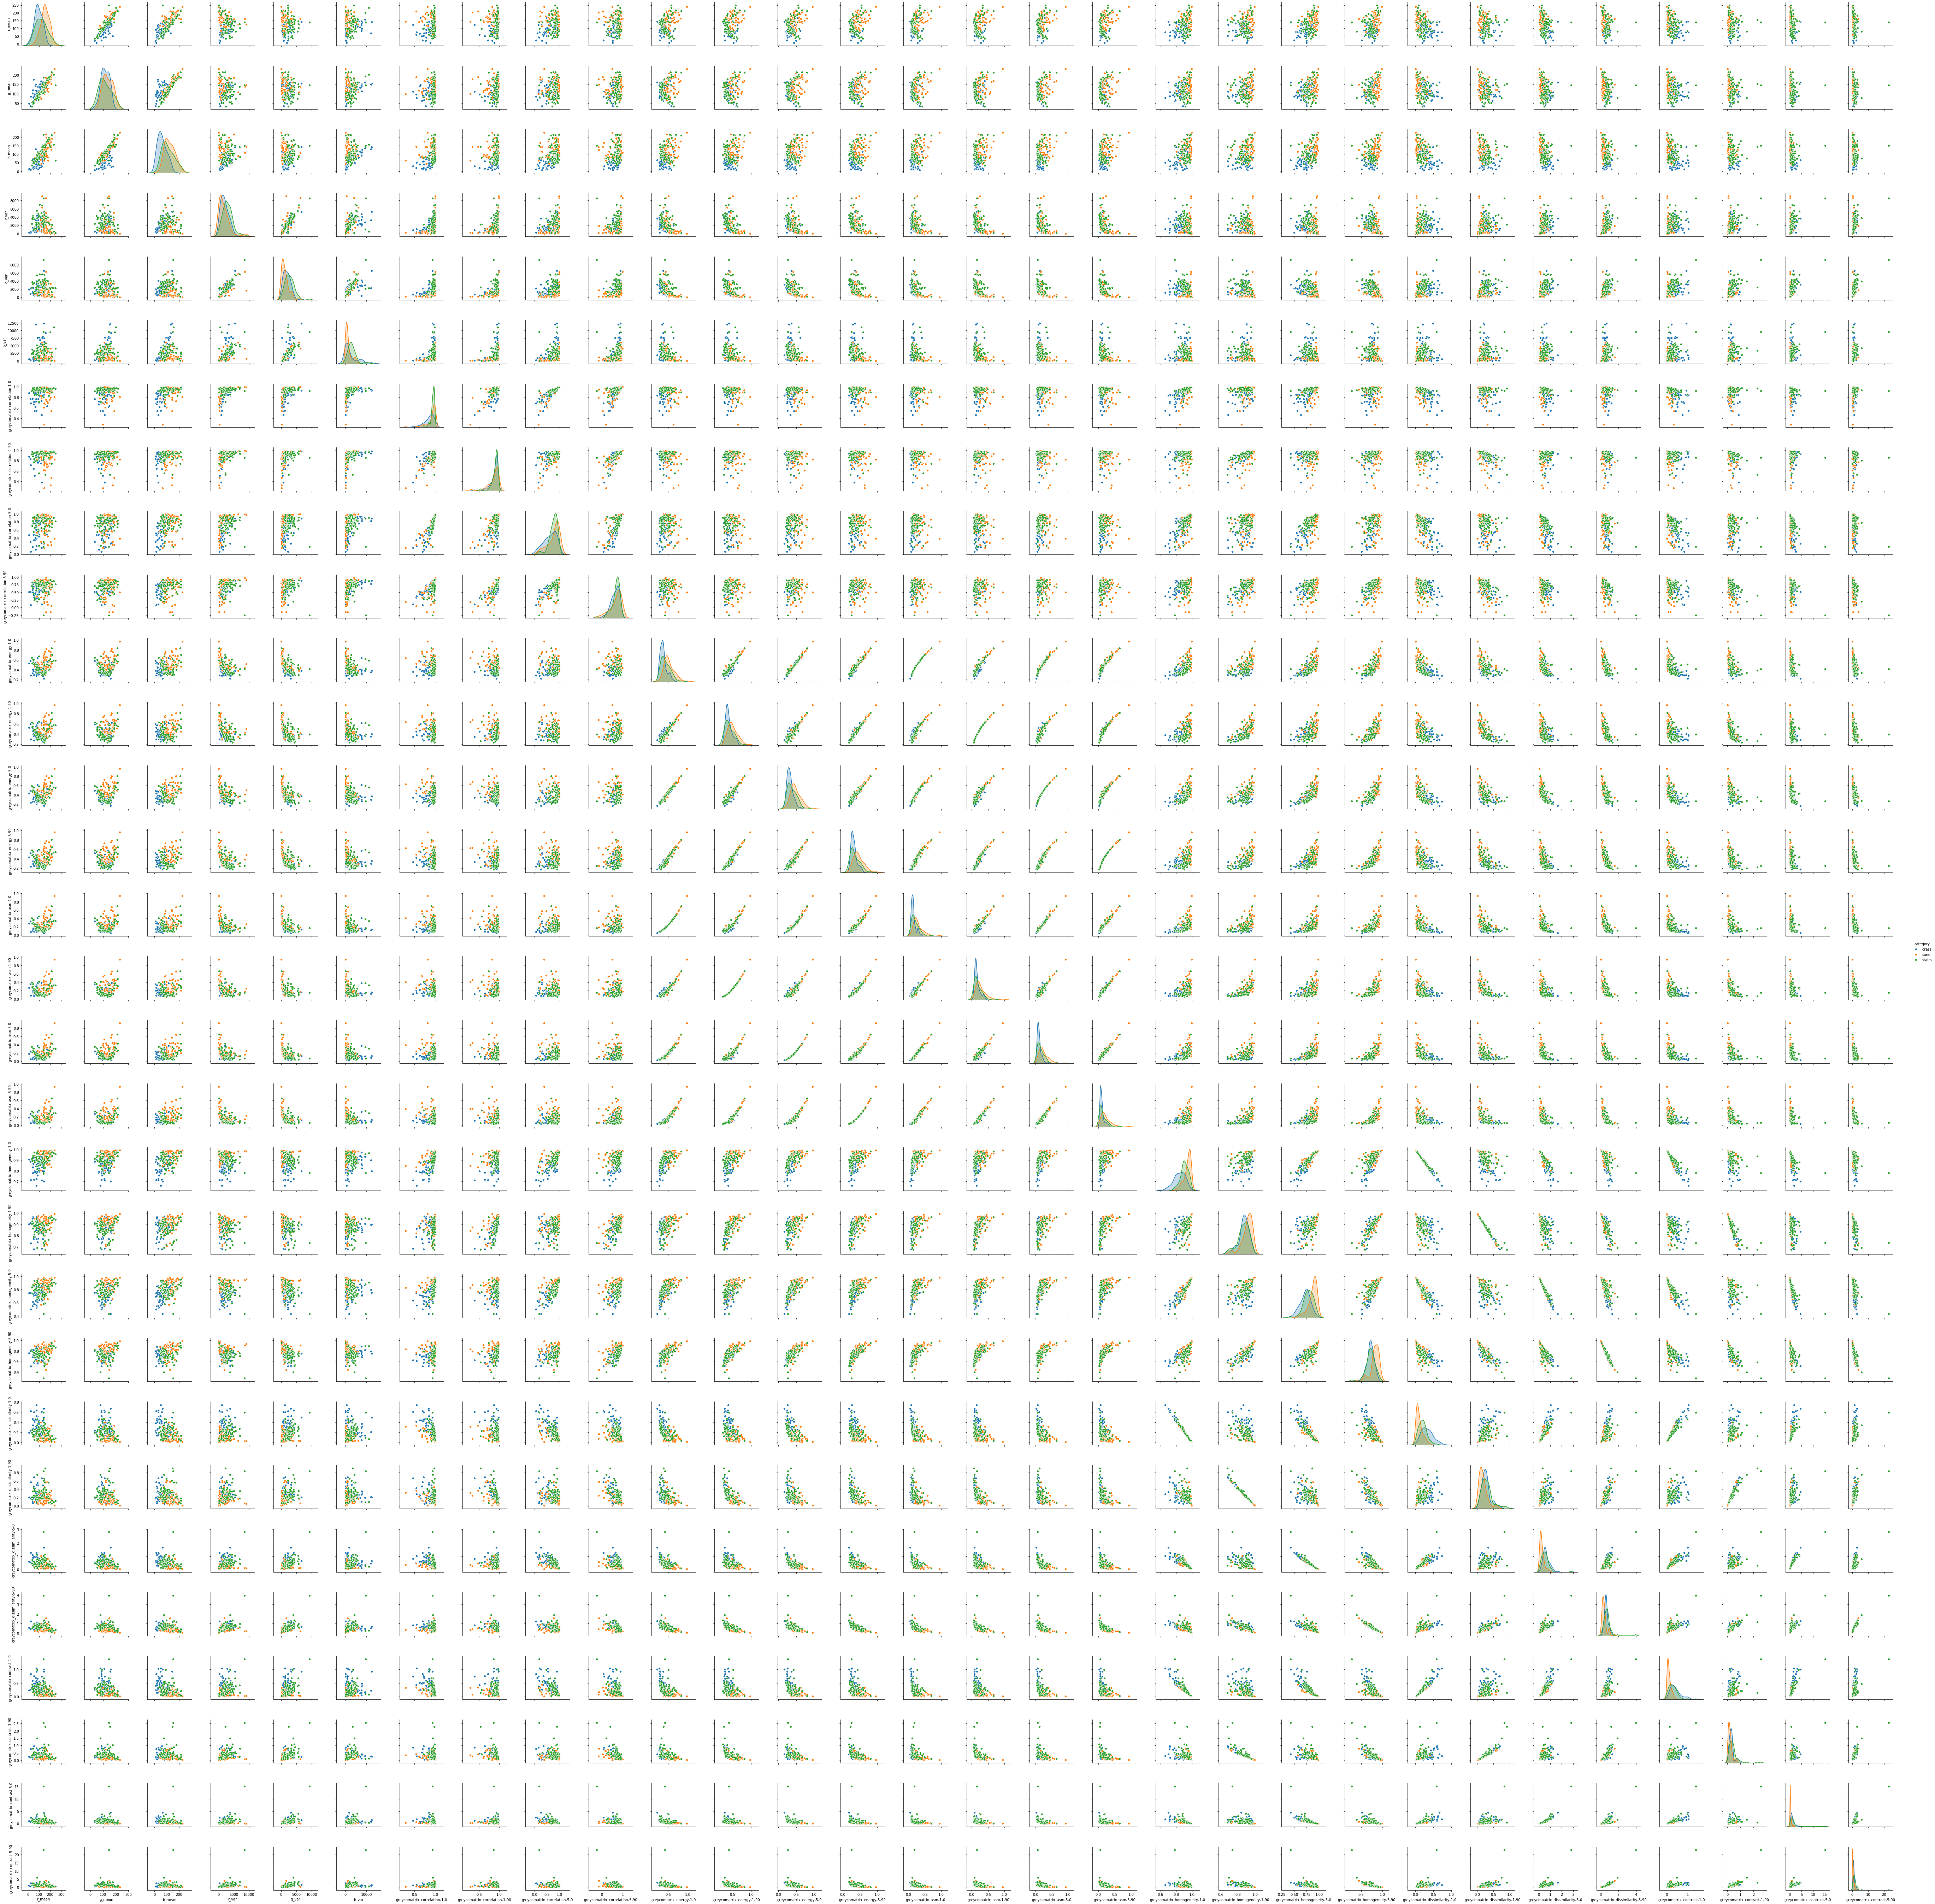

In [5]:
""" Visualizing feature pairs and their linearity with pairplot
"""

pairplot_keys = ['category','r_mean', 'g_mean', 'b_mean', 'r_var', 'g_var', 'b_var']
for f in genkey:
    for d in distances:
        for a in angles:
            pairplot_keys.append(f + "-" + str(d) + "-" + str(a))
""" Keys to use in pairplot
"""

result = images.loc[:, pairplot_keys]

g = sns.pairplot(result, hue='category')
plt.show()

In [6]:
""" Printing features which we noticed to have some linear depency in the above pairplot.
"""
display(pairplot_keys[11:19])
display(pairplot_keys[23] + " and " + pairplot_keys[19])
display(pairplot_keys[24] + " and " + pairplot_keys[20])
display(pairplot_keys[25] + " and " + pairplot_keys[21])
display(pairplot_keys[26] + " and " + pairplot_keys[22])


['greycomatrix_energy-1-0',
 'greycomatrix_energy-1-90',
 'greycomatrix_energy-5-0',
 'greycomatrix_energy-5-90',
 'greycomatrix_asm-1-0',
 'greycomatrix_asm-1-90',
 'greycomatrix_asm-5-0',
 'greycomatrix_asm-5-90']

'greycomatrix_dissimilarity-1-0 and greycomatrix_homogeneity-1-0'

'greycomatrix_dissimilarity-1-90 and greycomatrix_homogeneity-1-90'

'greycomatrix_dissimilarity-5-0 and greycomatrix_homogeneity-5-0'

'greycomatrix_dissimilarity-5-90 and greycomatrix_homogeneity-5-90'

### Discussion
The following features show some depency, but not that much to do any actual conclusions:
* Red mean (r_mean) and green mean (g_mean)
* Red mean (r_mean) and blue mean (b_mean)
* Green mean (g_mean) and blue mean (b_mean)
* Red variance (r_var) and Green variance (g_var)
* Greycomatrix feature energy and ASM, but as energy is square of ASM value, they have depency. Hence in the final classifier we can get rid of Greycomatrix energy feature.
* Greycomatrix dissimilarity and homogeneity. And as well, in the final classifier, we can get rid of Greycomatrix homogeneity feature.

### PCA

With PCA we can notice any clusters when we reduce the dimension.

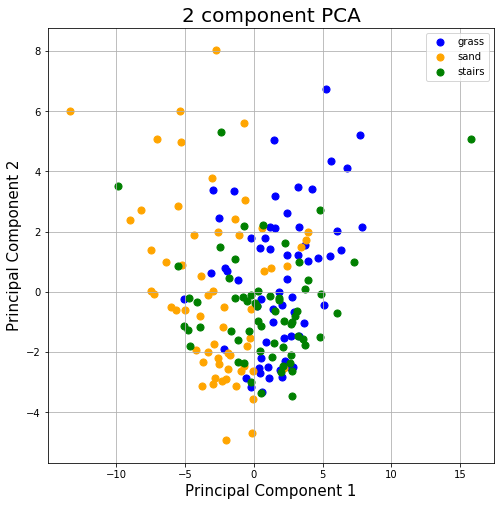

In [7]:
""" PCA

    Source    Date: 2.2.2020
    ------------------------------
    https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
"""

features = pairplot_keys[1:]
X = images.loc[:, features].values
y = images.loc[:,['category']].values
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, images.loc[:, 'category']], axis = 1)

""" Plotting the PCA
"""
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['grass', 'sand', 'stairs']
colors = ['blue', 'orange', 'green']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['category'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

#### PCA Analysis
As we can see now no clusters in principcal components, we are not going to use them in the model. This figure shows us that 'grass' and 'sand' labels can be distincted from each other pretty well but 'stairs' could be harder to distinct from these two, so 'stairs'-images would provide the worst predictions.

### Cleaning unnerssary features from the 'images'-dataframe to perserve memory usage.

In [8]:
""" Cleaning unnecessary features from the images dataframe, such as images, creycomatrixises and its features (the 2D ones) and the Greycomatrix homogeneity and Energy features totally as they are not needed.
"""
images.drop(['image', 'gray_image', 'greycomatrix', 'greycomatrix_correlation', 'greycomatrix_contrast', 'greycomatrix_homogeneity', 'greycomatrix_energy','greycomatrix_asm', 'greycomatrix_dissimilarity', 'greycomatrix_energy-1-0', 'greycomatrix_energy-1-90', 'greycomatrix_energy-5-0', 'greycomatrix_energy-5-90', 'greycomatrix_dissimilarity-1-0', 'greycomatrix_dissimilarity-1-90','greycomatrix_dissimilarity-5-0', 'greycomatrix_dissimilarity-5-90', 'greycomatrix_homogeneity-1-0', 'greycomatrix_homogeneity-1-90','greycomatrix_homogeneity-5-0', 'greycomatrix_homogeneity-5-90'], axis=1, inplace=True)

""" Display the head of images dataframe to validate we have data in nice format with the right features
"""
display(images.head())

category      r_mean      g_mean      b_mean        r_var        g_var  \
0    grass   59.433152   97.061349   20.962426   364.848413   457.992950   
1    grass  117.525387  137.627034  121.527695  4128.702703  3252.073048   
2    grass   23.520541   86.526053   12.751648   233.668662  2166.723073   
3    grass  100.180339  116.662128   21.299531   793.633755   920.524632   
4    grass  107.099293  150.654951   37.677554  2034.344788  1437.435782   

         b_var  greycomatrix_correlation-1-0  greycomatrix_correlation-1-90  \
0   152.928438                      0.538911                       0.512138   
1  5468.544932                      0.973947                       0.964268   
2   170.277629                      0.691963                       0.718619   
3   383.302193                      0.715420                       0.788980   
4  1325.119160                      0.890297                       0.953243   

   greycomatrix_correlation-5-0  greycomatrix_correlation-5-90  \
0                      0.345114                       0.331678   
1                      0.925967                       0.877011   
2                      0.063147                       0.082924   
3                      0.465580                       0.503737   
4                      0.739827                       0.778345   

   greycomatrix_asm-1-0  greycomatrix_asm-1-90  greycomatrix_asm-5-0  \
0              0.206592               0.202032              0.185130   
1              0.116945               0.108060              0.091422   
2              0.080320               0.085567              0.054438   
3              0.144307               0.167231              0.112398   
4              0.154956               0.192881              0.115954   

   greycomatrix_asm-5-90  greycomatrix_contrast-1-0  \
0               0.181374                   0.431357   
1               0.082049                   0.186608   
2               0.054696                   0.840101   
3               0.114226                   0.505879   
4               0.123444                   0.333090   

   greycomatrix_contrast-1-90  greycomatrix_contrast-5-0  \
0                    0.457688                   0.607256   
1                    0.256005                   0.531128   
2                    0.766508                   2.554051   
3                    0.374497                   0.951718   
4                    0.141332                   0.792436   

   greycomatrix_contrast-5-90  
0                    0.624356  
1                    0.883555  
2                    2.496161  
3                    0.875026  
4                    0.660534

## Build classifiers and estimate their performance

On this section we build three classifiers; kNN, Ridge Regression and Multilayer Perceptron, and validate their performance with Leave One Out and Nested Cross Validation. This shows us which classifier works best for this kind of features.

### kNN (k Nearest Neighbors classifier)

kNN is simple to understand classifier as the trained model is actually the whole data set where the new data prediction is added to the dataset and its nearest k-neighbours labels are checked and the new data is assigned to the majority class of these labels.

In here we split the data into train and testset (Leave One Out) and use nested cross-validation to optimize the hyperparameter (k) for the model with the current train set. We calculate the accuracy and confusion matrix for the usage of kNN with used features.

In [9]:
""" kNN
"""

X = images.loc[:, images.columns != 'category']
y = images.loc[:,['category']]

loo = LeaveOneOut()
""" We are using leave one out, as it provides better results and our system is strong enough to handle it
"""

predict_corr = 0
""" Counter for how many was predicted correctly
"""

predicted = []
""" Variable to save predicted values
"""

for train_index, test_index in loo.split(X):

    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]
    """ Splitting to train and test sets
    """
    
    ks = {}
    """ Dictionary to save k values with their accuracy
    """

    p=Pool(processes = mp.cpu_count()-1) 
    """ Process pool with max process count as the system's CPU count minus one
    """

    data = []
    for k in range(1,35):
        data.append((k, X_train, y_train, X_test, y_test))
    """ Appending variables to array for the multiprocessing function
        [(0.2, X_train, y_train, X_test, y_test), (0.4, X_train, y_train, X_test, y_test), ... (4.8, X_train, y_train, X_test, y_test)]
    """

    output = p.starmap(lobster.knn, data)
    """ Run the MLP as multiprocessing with the given data.
    """

    for o in output:
        ks[o[0]] = o[1]
    """ Save the output values (hidden layer size (int), accuracy (float)) to dictinary
    """
    
    best_k = int(max(ks, key=lambda k: ks[k]))
    """ Selecting the best k value from the dicionary of k values
    """
    
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(X_train, y_train.values.ravel())
    """ Setting kNN classifier and fitting the train sets to it
    """
    
    if knn.predict(X_test) == y_test['category'].iloc[0]:
        predict_corr += 1
    """ Testing did it predict right and incrementing predict correct variable by one in that case
    """
    
    predicted.append(knn.predict(X_test)[0])
    """ Adding the predicted value to predicted array
    """
    p.close()
    p.join()
    """ Closing current Pool of processes to ensure the processes are terminated and their memory released.
    """

Accuracy score for the model is 0.562162


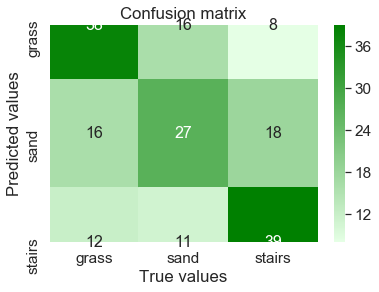

In [10]:
print("Accuracy score for the model is %f" % accuracy_score(y, predicted))
""" Accuracy score of the model.
"""

""" Confusion matrix
"""
confm = confusion_matrix(y, predicted, labels=["grass", "sand", "stairs"])
df_cm = pd.DataFrame(confm, ["grass", "sand", "stairs"], ["grass", "sand", "stairs"])
sns.set(font_scale=1.4)
pal = sns.light_palette("green", as_cmap=True)
sns.heatmap(df_cm, cmap=pal, annot=True, annot_kws={"size": 16})
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Confusion matrix")
plt.show()



### Discussion of kNN

As we can see from the accuracy score and from the confusion matrix, this classifier is not that good for this data and features.

### Ridge regression

In ridge regression, also known as Tikhonov regularization, we need to encode the labels ('grass', 'sand', 'stairs') to numerical discrete values. This classifier limits the complexity of the model compared to normal regression by adding bias (lambda) to lower variance of the future test data and predict better compared to Least Squares. Lambda value is optimized by nested cross validation.

Then we calculate the accuracy and confusion matrix for the Ridge Regression classifier for this data and features.

In [11]:
""" Encode the labels to numbers
"""
le = preprocessing.LabelEncoder()
le.fit(['grass', 'sand', 'stairs'])
y_dummy = le.transform(y.values.ravel())

loo = LeaveOneOut()
""" We are using leave one out, as it provides better results and our system is strong enough to handle it
"""

predict_corr = 0
""" Counter for how many was predicted correctly
"""

predicted = []
""" Variable to save predicted values
"""

for train_index, test_index in loo.split(X):

    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y_dummy[train_index], y_dummy[test_index]
    """ Splitting to train and test sets
    """
    
    a_s = {}
    """ Dictionary to save alpha values with their accuracy
    """
        
    p=Pool(processes = mp.cpu_count()-1) 
    """ Process pool with max process count as the system's CPU count minus one
    """

    data = []
    for a in np.arange(0.2, 5, 0.2):
        data.append((a, X_train, y_train, X_test, y_test))
    """ Appending variables to array for the multiprocessing function
        [(0.2, X_train, y_train, X_test, y_test), (0.4, X_train, y_train, X_test, y_test), ... (4.8, X_train, y_train, X_test, y_test)]
    """

    output = p.starmap(lobster.ridge, data)
    """ Run the MLP as multiprocessing with the given data.
    """

    for o in output:
        a_s[o[0]] = o[1]
    """ Save the output values (hidden layer size (int), accuracy (float)) to dictinary
    """
    
    best_a = float(max(a_s, key=lambda a: a_s[a]))
    """ Selecting the best alpha value from the dicionary of alpha values
    """
    
    clf = RidgeClassifier(alpha=best_a).fit(X_train, y_train)
    """ Setting Ridge classifier and fitting the train sets to it
    """
    
    prediction = clf.predict(X_test)
    if prediction[0] == y_test[0]:
        predict_corr += 1
    """ Testing did it predict right and incrementing predict correct variable by one in that case
    """
    
    predicted.append(prediction[0])
    """ Adding the predicted value to predicted array
    """
    
    p.close()
    p.join()
    """ Closing current Pool of processes to ensure the processes are terminated and their memory released.
    """

Accuracy score for the model is 0.789189


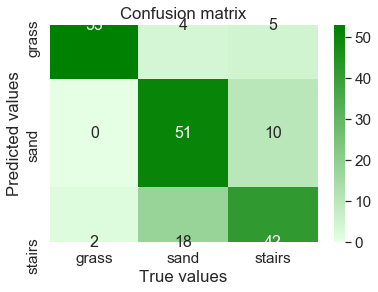

In [14]:
print("Accuracy score for the model is %f" % accuracy_score(y_dummy, predicted))
""" Accuracy score of the model.
"""

""" Confusion matrix
"""
confm = confusion_matrix(le.inverse_transform(y_dummy), le.inverse_transform(predicted), labels=["grass", "sand", "stairs"])
df_cm = pd.DataFrame(confm, ["grass", "sand", "stairs"], ["grass", "sand", "stairs"])
sns.set(font_scale=1.4)
pal = sns.light_palette("green", as_cmap=True)
sns.heatmap(df_cm, cmap=pal, annot=True, annot_kws={"size": 16})
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("Confusion matrix")
plt.show()


### Discussion of Ridge Regression

Accuracy score and Confusion Matrix looks very promising and would be safe to say this model predicts pretty well for the new unknown data.

 ### Multi-layer perceptron

Similar to kNN and Ridge Regression, we build new classifier; Multilayer perceptron. We are going to use only one hidden layer and optimize its neuron size with nested cross validation. Multilayer perceptron is deep learning method which uses backpropagation algorithm for training. 

Other Multilayer perceptron properties:
* Solver for weight optimization: stochastic gradient-based optimizer
* Activation function for the hidden layer: rectified linear unit function
* Early stop commitee with 50% of training data for validation


In [15]:
loo = LeaveOneOut()
""" We are using leave one out, as it provides better results and our system is strong enough to handle it
"""

predict_corr = 0
""" Counter for how many was predicted correctly
"""

predicted = []
""" Variable to save predicted values
"""

for train_index, test_index in loo.split(X):

    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]
    """ Splitting to train and test sets
    """
    
    l_sizes = {}
    """ Dictionary to save hidden layer neuron amount with their accuracy
    """
        
    p=Pool(processes = mp.cpu_count()-1) 
    """ Process pool with max process count as the system's CPU count minus one
    """

    data = []
    for i in range(3,61):
        data.append((i, X_train, y_train, X_test, y_test))
    """ Appending variables to array for the multiprocessing function
        [(3, X_train, y_train, X_test, y_test), (4, X_train, y_train, X_test, y_test), ... (60, X_train, y_train, X_test, y_test)]
    """

    output = p.starmap(lobster.mlp, data)
    """ Run the MLP as multiprocessing with the given data.
    """

    for o in output:
        l_sizes[o[0]] = o[1]
    """ Save the output values (hidden layer size (int), accuracy (float)) to dictinary
    """
        
    best_lsize = int(max(l_sizes, key=lambda lsize: l_sizes[lsize]))
    """ Selecting the best hidden layer size from the dicionary of hidden layer sizes
    """
    
    mlp = MLPClassifier(solver='adam', activation='relu', validation_fraction=0.5, early_stopping=True, alpha=1e-5, hidden_layer_sizes=(best_lsize,), random_state=1)
    mlp.fit(X_train, y_train.values.ravel())
    """ Setting Multilayer Perceptron classifier and fitting the train sets to it
    """
    
    prediction = mlp.predict(X_test)
    if prediction[0] == y_test.iloc[0][0]:
        predict_corr += 1
    """ Testing did it predict right and incrementing predict correct variable by one in that case
    """
    
    predicted.append(prediction[0])
    """ Adding the predicted value to predicted array
    """
    
    p.close()
    p.join()
    """ Closing current Pool of processes to ensure the processes are terminated and their memory released.
    """
    

Accuracy score for the model is 0.513514


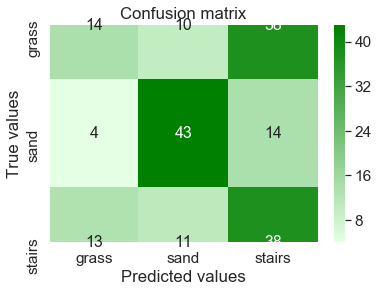

In [16]:
print("Accuracy score for the model is %f" % accuracy_score(y, predicted))
""" Accuracy score of the model.
"""

""" Confusion matrix
"""
confm = confusion_matrix(y, predicted)
df_cm = pd.DataFrame(confm, ["grass", "sand", "stairs"], ["grass", "sand", "stairs"])
sns.set(font_scale=1.4) # for label size
pal = sns.light_palette("green", as_cmap=True)
sns.heatmap(df_cm, cmap=pal, annot=True, annot_kws={"size": 16}) # font size
plt.ylabel("True values")
plt.xlabel("Predicted values")
plt.title("Confusion matrix")
plt.show()

### Discussion of Multilayer Perceptron

This classifier is computational heavy and this data set might be too small for it. Accuracy and confusion matrix shows us that this model is not very good for this kind of data.

# Discussion of the results
    
Ridge Regression with accuracy score of 78.9% performed better than kNN (56.2%) and Multilayer Perceptron (51.4%), hence for this kind of data amount and features. It could be argued that if Multilayer Perceptron would have more data and features, it would perform better, altought training it would be a limitation as it takes long time. As such, kNN might be too 'simple' model to be used in this kind of prediction task for this kind of data, further test need to be conducted to validate is kNN generally bad for this kind of image recognition or is it just the data (images) type reason for lower accuracy score compared to Ridge Regression [1](http://www.wseas.us/e-library/conferences/2012/CambridgeUSA/MATHCC/MATHCC-18.pdf).

In these classifiers, their hyperparamater were optimized with nested cross-validation, altough one feature from the data was generated with arbitrary value; distance in GLCM, this value could affect the training and prediction of these classifiers and it should be optimized. Only way to optimize this value would test different values on it and run these tests through, but as all of these steps take total of six hours, it is not feasible to test the distance with values 2, .., 100. Aswell, it would be interesting to test the effect of different quantization levels of the gray images.

Also Gray-Level-Run-Length-Matrix could provide some better features for these classifiers but on this document it was not implented.

### External file 'lobster.py'
This file includes the functions used in multiprocessing.

_Only view, not to be run from here or modified_

In [ ]:
# %load lobster.py
""" Module to used in multiprocess machine learning with nested cross validation.

Functions on this module are multilayer perceptron, and ...

Author:
    Marko Loponen
    majulop@utu.fi
    University of Turku

Versions and dates:
    6.2.2020: Initial and added multilayer perceptron function.

Todo:
    * Add kNN and Ridge Regression

"""

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import LeaveOneOut
""" Importing needed modules for this module
"""

def mlp(lsize, X_train, y_train, X_test, y_test):
    """ Multilayer Perceptron classifier

    Trains the model and predicts with the test set.

    Args:
        lsize (int): Neuron size.
        X_train (Pandas.DataFrame): Train set features.
        y_train (Pandas.DataFrame): Train set labels.
        X_test (Pandas.DataFrame): Test set features.
        y_test (Pandas.DataFrame): Test set labels

    Returns:
        tuple:  Tuple with value of Hidden layer size (int) and it's accuracy (float).
                Example: (3, 0.64302)
            
    """
    
    inner_predict_corr = 0
    """ Counter for how many was predicted correctly in the inner loop
    """
    
    loo_inner = LeaveOneOut()
    """ Leave one out
    """

    for inner_train_index, inner_test_index in loo_inner.split(X_train):
        
        inner_X_train, inner_X_test = X_train.iloc[inner_train_index,:], X_train.iloc[inner_test_index,:]
        inner_y_train, inner_y_test = y_train.iloc[inner_train_index,:], y_train.iloc[inner_test_index,:]
        """ Splitting to train and test sets
        """

        mlp = MLPClassifier(solver='adam', activation='relu', validation_fraction=0.5, early_stopping=True, alpha=1e-5, hidden_layer_sizes=(lsize,), random_state=1)
        mlp.fit(inner_X_train, inner_y_train.values.ravel())
        """ Setting Multilayer Perceptron classifier and fitting the inner train sets to it
        """
        
        if mlp.predict(inner_X_test)[0] == inner_y_test.iloc[0][0]:
            inner_predict_corr += 1
        """ Testing did it predict right and incrementing inner predict correct variable by one in that case
        """

    return (str(lsize), inner_predict_corr / X_train.shape[0])

def ridge(a, X_train, y_train, X_test, y_test):
    """ Ridge Regression classifier

    Trains the model and predicts with the test set.

    Args:
        a (int): Alpha value.
        X_train (Pandas.DataFrame): Train set features.
        y_train (Pandas.DataFrame): Train set labels.
        X_test (Pandas.DataFrame): Test set features.
        y_test (Pandas.DataFrame): Test set labels

    Returns:
        tuple:  Tuple with value of Alpha (float) and it's accuracy (float).
                Example: (0.2, 0.64302)
            
    """
    
    inner_predict_corr = 0
    """ Counter for how many was predicted correctly in the inner loop
    """

    loo_inner = LeaveOneOut()
    """ Leave one out
    """

    for inner_train_index, inner_test_index in loo_inner.split(X_train):

        inner_X_train, inner_X_test = X_train.iloc[inner_train_index,:], X_train.iloc[inner_test_index,:]
        inner_y_train, inner_y_test = y_train[inner_train_index], y_train[inner_test_index]
        """ Splitting the inner fold to train and test sets
        """

        clf = RidgeClassifier(alpha=a).fit(inner_X_train, inner_y_train)
        """ Setting Ridge classifier and fitting the inner train sets to it
        """

        if clf.predict(inner_X_test) == inner_y_test[0]:
            inner_predict_corr += 1
        """ Testing did it predict right and incrementing inner predict correct variable by one in that case
        """
        
    return (str(a), inner_predict_corr / X_train.shape[0])

def knn(k, X_train, y_train, X_test, y_test):
    """ kNN classifier

    Trains the model and predicts with the test set.

    Args:
        k (int): k-nearest neighbours.
        X_train (Pandas.DataFrame): Train set features.
        y_train (Pandas.DataFrame): Train set labels.
        X_test (Pandas.DataFrame): Test set features.
        y_test (Pandas.DataFrame): Test set labels

    Returns:
        tuple:  Tuple with value of k (int) and it's accuracy (float).
                Example: (3, 0.64302)
            
    """
    
    inner_predict_corr = 0
    """ Counter for how many was predicted correctly in the inner loop
    """

    loo_inner = LeaveOneOut()
    """ Leave one out
    """

    for inner_train_index, inner_test_index in loo_inner.split(X_train):

        inner_X_train, inner_X_test = X_train.iloc[inner_train_index,:], X_train.iloc[inner_test_index,:]
        inner_y_train, inner_y_test = y_train.iloc[inner_train_index,:], y_train.iloc[inner_test_index,:]
        """ Splitting the inner fold to train and test sets
        """

        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(inner_X_train, inner_y_train.values.ravel())
        """ Setting kNN classifier and fitting the train sets to it
        """

        if knn.predict(inner_X_test) == inner_y_test['category'].iloc[0]:
            inner_predict_corr += 1
        """ Testing did it predict right and incrementing inner predict correct variable by one in that case
        """
        
    return (str(k), inner_predict_corr / X_train.shape[0])